In [1343]:
# pip install rich numpy pandas matplotlib

import rich, math, sys, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rich.console import Console
from rich.live import Live
from rich.text import Text
from dataclasses import dataclass, field
from typing import List, Dict, Any, Optional, ClassVar, Union
from functools import reduce
from IPython.display import clear_output  # For Jupyter compatibility

In [1555]:
# constants
BLE_BANDWIDTH = 1000 * 1000 * 2 # b/s
BLE_BANDWIDTH_B_MS = BLE_BANDWIDTH / 8 / 1000 # B/ms
FIRST_PRIMES_BEFORE_200 = [
    2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47,
    53, 59, 61, 67, 71, 73, 79, 83, 89, 97,
    101, 103, 107, 109, 113, 127, 131, 137, 139, 149,
    151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199
]

TIME_PADDING = 1 # ms

SLOT_INFO = {
    "beacon": {
        "direction": "down",
        "is_shared": True,
        "abbreviation": "B",
        "color": "red",
    },
    "data-down": {
        "direction": "down",
        "is_shared": True,
        "abbreviation": "D",
        "color": "green",
    },
    "data-up": {
        "direction": "up",
        "is_shared": False,
        "abbreviation": "U",
        "color": "yellow",
    },
    "data-shared-up": {
        "direction": "up",
        "is_shared": True,
        "abbreviation": "S",
        "color": "purple",
    },

    # not used anymore -- will just use data-down for carrying join-response packets
    "join-response": {
        "direction": "down",
        "is_shared": True,
        "abbreviation": "R",
        "color": "deep_pink3",
    },

    # so far not used
    "empty": {
        "direction": "n/a",
        "is_shared": False,
        "abbreviation": "E",
        "color": "white",
    },
}

@dataclass
class Packet:
    mtu: int = 256 # B

    @property
    def toa(self):
        return self.mtu / BLE_BANDWIDTH_B_MS

PACKET = Packet()

@dataclass
class Slot:
    type: str
    start: Optional[float] = None

    def __post_init__(self):
        assert self.type in SLOT_INFO, f"Unknown slot type: {self.type}"

    @staticmethod
    def from_abbreviation(abbrev):
        for type, info in SLOT_INFO.items():
            if info["abbreviation"] == abbrev:
                return Slot(type)
        raise ValueError(f"Unknown slot abbreviation: {ord(abbrev)}")

    @property
    def direction(self):
        return SLOT_INFO[self.type]["direction"]

    @property
    def is_shared(self):
        return SLOT_INFO[self.type]["is_shared"]

    @property
    def duration(self):
        return PACKET.toa + TIME_PADDING

    @property
    def end(self):
        return self.start + self.duration
    
    @property
    def abbrev(self):
        return SLOT_INFO[self.type]["abbreviation"]

    def __str__(self):
        return f"{self.type} slot, from {self.start:.2f} to {self.end:.2f} ({PACKET.mtu} B Packet)"
    
    def __repr__(self):
        return self.__str__()

    def repr_nice(self, compact=False):
        """
        Return a single character with rich-based background color (based on type).
        """
        abbrev = SLOT_INFO[self.type]['abbreviation']
        color = SLOT_INFO[self.type]["color"]
        direction = "↓" if self.direction == "down" else " " # invisible space!!
        if compact:
            # return rich.text.Text(abbrev, style=f'bold {color} on {color}')
            if self.direction == "down":
                return rich.text.Text("↓", style=f'bold white on {color}')
            return rich.text.Text(abbrev, style=f'bold {color} on {color}')
        else:
            # add invisible []'s because space doesn't work well with newlines
            hidden_left = rich.text.Text("[", style=f'bold {color} on {color}')
            # hidden_right = rich.text.Text("]", style=f'bold {color} on {color}')
            if self.direction == "down":
                hidden_right = rich.text.Text("↓", style=f'bold white on {color}')
            else:
                hidden_right = rich.text.Text("]", style=f'bold {color} on {color}')
            chr = rich.text.Text(abbrev, style=f'bold white on {color}')
            return hidden_left + chr + hidden_right

class SlotFactory:
    def beacon(n=3):
        return [Slot("beacon") for _ in range(n)]

    def join_request(n):
        return [Slot("data-up-shared") for _ in range(n)]

    def data_down(n):
        return [Slot("data-down") for _ in range(n)]

    def data_up(n):
        return [Slot("data-up") for _ in range(n)]

@dataclass
class Slotframe:
    slots: list[Slot]

    @staticmethod
    def from_nested(nested_slots):
        """Creates a Slotframe from nested slots, supporting both lists and single Slot objects."""
        # Use reduce to flatten nested structures automatically
        def flatten(acc, item):
            if isinstance(item, list):
                return acc + item
            return acc + [item]
        
        slots = reduce(flatten, nested_slots if isinstance(nested_slots, list) else [nested_slots], [])
        return Slotframe(slots)

    @staticmethod
    def build(abbreviations, start=0):
        """Creates a Slotframe from a string of abbreviations, e.g., 'BDDUS' """
        slots = [Slot.from_abbreviation(abbrev) for abbrev in abbreviations if abbrev != " " and abbrev != "\n"]
        for slot in slots:
            slot.start = start
            start += slot.duration
        return Slotframe(slots)

    @staticmethod
    def build_blocks(assoc_slots, data_slots, repetitions=1):
        """Creates a Slotframe from a string of abbreviations, e.g., 'BDDUS' """
        abbreviations = (assoc_slots + data_slots) * repetitions
        return Slotframe.build(abbreviations)

    @staticmethod
    def build_blocks2(data_slots, repeats_data=1, assoc_slots="BS", repeats_assoc=1, force_prime="U"):
        """Creates a Slotframe from a string of abbreviations, e.g., 'BDDUS' """
        abbreviations = (assoc_slots + data_slots * repeats_data) * repeats_assoc
        if force_prime in ["U", "D", "S", "B", "E"]:
            diff = abs(len(abbreviations) - Slotframe.closest_prime_above(len(abbreviations)))
            abbreviations += force_prime * diff
        return Slotframe.build(abbreviations)

    def __str__(self):
        return f"Slotframe: {len(self.slots)} slots"

    @property
    def slot_duration(self):
        return self.slots[0].duration

    @property
    def duration(self):
        return round(len(self.slots) * self.slot_duration, 2)
    
    @property
    def start(self):
        return self.slots[0].start
    
    @property
    def end(self):
        return self.slots[-1].end

    @property
    def slot_count(self):
        return len(self.slots)
    
    def as_raw_abbreviations(self):
        return "".join([SLOT_INFO[slot.type]["abbreviation"] for slot in self.slots])

    def count_slots_per_type(self, abbreviations=False):
        """Count the number of slots per type."""
        counts = {}
        for slot in self.slots:
            if slot.type not in counts:
                counts[slot.type] = 1
            else:
                counts[slot.type] += 1
        if abbreviations:
            return {SLOT_INFO[type]["abbreviation"]: count for type, count in counts.items()}
        return counts

    def max_nodes(self):
        """Return the maximum number of nodes that can be scheduled in the slotframe."""
        return self.count_slots_per_type().get("data-up", 0)
    
    def ratio_data_up_to_data_down(self):
        return round(self.count_slots_per_type().get("data-up", 0) / self.count_slots_per_type().get("data-down", 1), 2)

    @staticmethod
    def closest_prime_number(n_slots):
        """Find the closest prime number to the number of slots."""
        return min(FIRST_PRIMES_BEFORE_200, key=lambda x: abs(x - len(n_slots)))

    @staticmethod
    def closest_prime_above(n_slots):
        """Find the closest prime number greater than or equal to the number of slots."""
        for prime in FIRST_PRIMES_BEFORE_200:
            if prime >= n_slots:
                return prime

    @staticmethod
    def closest_prime_below(n_slots):
        """Find the closest prime number less than or equal to the number of slots."""
        for prime in reversed(FIRST_PRIMES_BEFORE_200):
            if prime <= n_slots:
                return prime

    def find_first_slot(self, type):
        """Find the first slot of a given type, including index."""
        return next(((i, slot) for i, slot in enumerate(self.slots) if slot.type == type), (None, None))
    
    def find_last_slot(self, type):
        """Find the last slot of a given type, including index."""
        return next(((j, slot) for j, slot in reversed(list(enumerate(self.slots))) if slot.type == type), (None, None))

    def repr_nice(self, compact=False):
        """Return a rich-based representation of the slotframe."""
        schedule = [slot.repr_nice(compact) for slot in self.slots]
        return rich.text.Text.assemble(*schedule)
    
    def show(self, compact=False):
        """Show the schedule of the slotframe."""
        console = Console()
        console.print(self.repr_nice(compact), end="\n", soft_wrap=compact)

    def show_stats(self, compact=False, otap_size=10_000):
        """Show scheduling statistics of the slotframe. Reuse the repr_nice method of the Slot class."""
        console = Console()
        schedule = [slot.repr_nice(compact) for slot in self.slots]
        console.print(f"Slotframe with {len(self.slots)} slots of {self.slot_duration:.2f} ms each (total {self.duration:.2f} ms):")
        # console.print(*schedule, end="\n")
        console.print(rich.text.Text.assemble(*schedule), end="\n", soft_wrap=compact)
        console.print(f"""\
- Max nodes: {self.max_nodes()} (number of data-up slots)

- MTU per slot: {PACKET.mtu} B
- Slot duration: {self.slot_duration:.2f} ms (TOA: {PACKET.toa:.2f} ms, PAD: {TIME_PADDING} ms)
- Number of slots per type: {self.count_slots_per_type()}
- Ratio of data-up to data-down slots: {self.ratio_data_up_to_data_down()}
""")
        return self


# example usage
sf = Slotframe.build_blocks2(data_slots="DUSU", repeats_data=3, assoc_slots="BS", repeats_assoc=1, force_prime="E")
sf.show_stats(compact=False)

Slotframe with 17 slots of 2.02 ms each (total 34.41 ms):

[B↓[S][D↓[U][S][U][D↓[U][S][U][D↓[U][S][U][E][E][E]

- Max nodes: 6 (number of data-up slots)

- MTU per slot: 256 B
- Slot duration: 2.02 ms (TOA: 1.02 ms, PAD: 1 ms)
- Number of slots per type: {'beacon': 1, 'data-shared-up': 4, 'data-down': 3, 'data-up': 6, 'empty': 3}
- Ratio of data-up to data-down slots: 2.0

Slotframe(slots=[beacon slot, from 0.00 to 2.02 (256 B Packet), data-shared-up slot, from 2.02 to 4.05 (256 B Packet), data-down slot, from 4.05 to 6.07 (256 B Packet), data-up slot, from 6.07 to 8.10 (256 B Packet), data-shared-up slot, from 8.10 to 10.12 (256 B Packet), data-up slot, from 10.12 to 12.14 (256 B Packet), data-down slot, from 12.14 to 14.17 (256 B Packet), data-up slot, from 14.17 to 16.19 (256 B Packet), data-shared-up slot, from 16.19 to 18.22 (256 B Packet), data-up slot, from 18.22 to 20.24 (256 B Packet), data-down slot, from 20.24 to 22.26 (256 B Packet), data-up slot, from 22.26 to 24.29 (256 B Packet), data-shared-up slot, from 24.29 to 26.31 (256 B Packet), data-up slot, from 26.31 to 28.34 (256 B Packet), empty slot, from 28.34 to 30.36 (256 B Packet), empty slot, from 30.36 to 32.38 (256 B Packet), empty slot, from 32.38 to 34.41 (256 B Packet)])

In [752]:
@dataclass
class Latency():
    sf: Slotframe

    def worst_case_downlink(self):
        """The diff between the last uplink and the first downlink."""
        i, first_down = self.sf.find_first_slot("data-down")
        j, last_up = self.sf.find_last_slot("data-up")
        return round(last_up.end - first_down.start, 2)
    def worst_case_uplink_estimate(self):
        """
        Just an estimate for the worst case latency, when all nodes are waiting for a downlink reply.

        - this is basically using the ratio of uplink to downlink slots, and assuming that we are the last in queue to receive a downlink reply.
        - this only makes sense for potential scenarios where the robot wants to perform a request-response style communication, e.g., EDHOC handshake.
        """
        sf_up = self.sf.count_slots_per_type()["data-up"]
        sf_down = self.sf.count_slots_per_type()["data-down"]
        needed_sf_n = math.ceil(sf_up / sf_down)
        return round(needed_sf_n * self.sf.duration, 2)
    
    def show_stats(self):
        console = Console()
        console.print(f"""\
Latency worst case:

- downlink/uplink reply:            {self.worst_case_downlink()} ms
- uplink/downlink reply (estimate): {self.worst_case_uplink_estimate()} ms
    """)
    
Latency(sf).show_stats()

Latency worst case:

- downlink/uplink reply:            30.36 ms
- uplink/downlink reply (estimate): 103.23 ms

In [754]:
@dataclass
class OTAP:
    sf: Slotframe

    def duration(self, size=10_000):
        return self.get_stats(size)["duration"]

    def get_stats(self, size=10_000):
        swarmit_chunk_size = 128 # B
        packets = math.ceil(size / swarmit_chunk_size)
        data_down_slots = self.sf.count_slots_per_type()["data-down"]
        needed_slotframes = math.ceil(packets / data_down_slots)
        return {
            "image_size": math.ceil(size / 1024),
            "duration": round(needed_slotframes * self.sf.duration, 2),
            "packets": packets,
            "swarmit_chunk_size": swarmit_chunk_size,
            "needed_slotframes": needed_slotframes,
        }
        
    def show_stats(self, size=10_000):
        """Calculate the duration of an OTAP session."""
        stats = self.get_stats(size)
        console = Console()
        console.print(f"""\
OTAP update:

- Image size: {math.ceil(size / 1024)} kB
- Duration: {round(stats["duration"] / 1000, 2)} s

- Packets: {stats["packets"]}
- swarmit_chunk_size: {stats["swarmit_chunk_size"]} B
- Needed slotframes: {stats["needed_slotframes"]}
    """)
        
# example usage
OTAP(sf).show_stats()

OTAP update:

- Image size: 10 kB
- Duration: 0.93 s

- Packets: 79
- swarmit_chunk_size: 128 B
- Needed slotframes: 27

In [840]:
@dataclass
class Association():
    sf: Slotframe

    def max_time_no_collisions_est(self):
        """
        Just an estimate for the maximum association time, provided that there are no collisions.
        """
        sf_shared_up = self.sf.count_slots_per_type()["data-shared-up"]
        needed_sf_n = math.ceil(self.sf.max_nodes() / sf_shared_up)
        return round(needed_sf_n * self.sf.duration, 2)
    
    def show_stats(self):
        console = Console()
        console.print(f"""\
Association time:

- Max time no collisions (estimate):            {self.max_time_no_collisions_est()} ms
    """)
    
Association(sf).show_stats()

Association time:

- Max time no collisions (estimate):            2056.4 ms

# Testing different schedules

In [1518]:
@dataclass
class SFConfigs:
    slotframes: list[Slotframe]
    otap_size: int = 10_000

    def get_df(self):
        headers = [
            "slot_count", "U-max_nodes", "D-down", "S-join_req", "ratio_U_D",
            "sf_duration", "max_gw_req_res", "max_db_req_res", "otap_duration",
        ]
        stats = [
            [
                sf.slot_count,
                sf.max_nodes(),
                sf.count_slots_per_type()["data-down"],
                sf.count_slots_per_type()["data-shared-up"],
                sf.ratio_data_up_to_data_down(),
                sf.duration,
                Latency(sf).worst_case_downlink(),
                Latency(sf).worst_case_uplink_estimate(),
                OTAP(sf).duration(self.otap_size),
            ]
            for sf in self.slotframes
        ]

        return pd.DataFrame(stats, columns=headers)

    def show_df(self):
        display(self.get_df())

    def show_schedules(self, compact=True):
        """Display compact slotframes with prepended indices and newlines."""
        texts = []
        for i, sf in enumerate(self.slotframes):
            # Prepend index and avoid extra spaces
            index_text = rich.text.Text(f"{i}: ", style="bold magenta", end="")
            slotframe_text = sf.repr_nice(compact=compact)
            newline = rich.text.Text("\n", end="")
            texts.append(rich.text.Text.assemble(index_text, slotframe_text, newline))

        console = Console()
        # Use '\n' to join the lines explicitly for precise layout
        combined_text = rich.text.Text("\n").join(texts)
        console.print(combined_text, end="", soft_wrap=True)

    def show_stats(self, compact=True):
        """Display statistics for all slotframes."""
        self.show_df()
        self.show_schedules(compact)
        return self

# example usage
sf_configs = SFConfigs([
    Slotframe.build_blocks2("DUSU", 3, force_prime="E"),
], otap_size=30_000).show_stats(compact=False)

,slot_count,U-max_nodes,D-down,S-join_req,ratio_U_D,sf_duration,max_gw_req_res,max_db_req_res,otap_duration
0,17,6,3,4,2.0,34.41,24.29,68.82,2718.39


0: [B↓[S][D↓[U][S][U][D↓[U][S][U][D↓[U][S][U][E][E][E]

In [1559]:
# different slotframe configurations to compare
sf_configs = SFConfigs([
    # build_blocks2(data_slots, repeats_data=1, assoc_slots="BS", repeats_assoc=1, force_prime="E")

    # keeping the (candiate) best slotframe at position 0
    Slotframe.build_blocks2("SDUUUDUUU", 12, "BBB"),

    # Slotframe.build_blocks2("SDUUUUDUUU", 12, "BBB", repeats_assoc=1),
    # # Slotframe.build_blocks2("SDUUUUDUUU", 4, "B", repeats_assoc=3),

    # Slotframe.build_blocks2("SDUUUUUDUUUU", 4, "B", repeats_assoc=3),
    # Slotframe.build_blocks2("DUUUSDUUU", 12, "BS"),
    # Slotframe.build_blocks2("DUUUUDUUUU", 12, "BS"),

    # # just a very simple slotframe
    # Slotframe.build_blocks2("SDUUU", 5, "BBB", force_prime="U")

], otap_size=30_000).show_stats()

,slot_count,U-max_nodes,D-down,S-join_req,ratio_U_D,sf_duration,max_gw_req_res,max_db_req_res,otap_duration
0,113,74,24,12,3.08,228.71,220.62,914.84,2287.1


0: ↓↓↓S↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUUU

Slotframe with 113 slots of 2.02 ms each (total 228.71 ms):

↓↓↓S↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUUU

- Max nodes: 74 (number of data-up slots)

- MTU per slot: 256 B
- Slot duration: 2.02 ms (TOA: 1.02 ms, PAD: 1 ms)
- Number of slots per type: {'beacon': 3, 'data-shared-up': 12, 'data-down': 24, 'data-up': 74}
- Ratio of data-up to data-down slots: 3.08

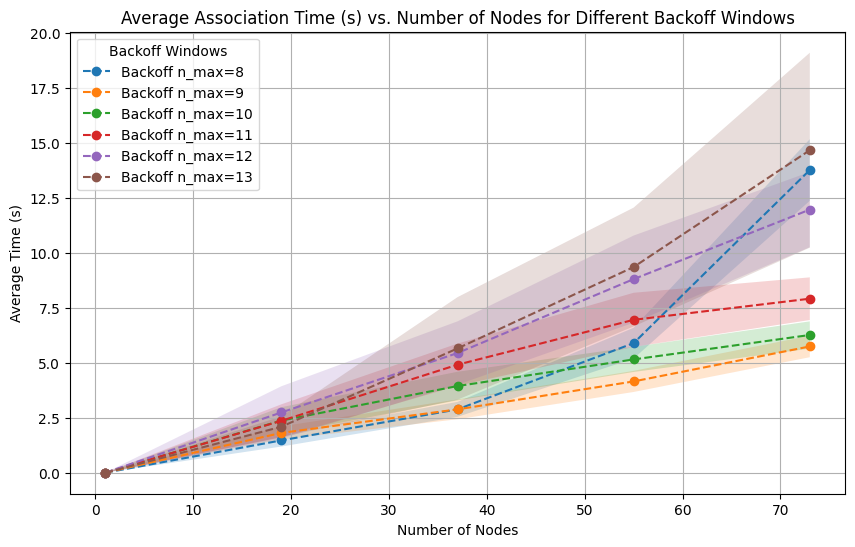

In [1563]:
sf = sf_configs.slotframes[0] # a good slotframe
# sf = sf_configs.slotframes[-1] # a very simple slotframe

sf.show_stats(compact=True)

# df = run_association_simulations(sf, splits_nodes=4, range_backoff=range(8, 14), number_of_runs=20)
plot_association_simulation_results(df)

# Scratchpad

In [1071]:
sf = sf_configs.slotframes[0].show_stats()

Latency(sf).show_stats()
OTAP(sf).show_stats(size=30_000)
Association(sf).show_stats()

Slotframe with 113 slots of 2.02 ms each (total 228.71 ms):

[B↓[B↓[B↓[S][D↓[U][U][U][D↓[U][U][U][S][D↓[U][U][U][D↓[U][U][U][S][D↓[U][U][U][D↓[U][U][U][S][D↓[U][U][U][D↓[U][U][
U][S][D↓[U][U][U][D↓[U][U][U][S][D↓[U][U][U][D↓[U][U][U][S][D↓[U][U][U][D↓[U][U][U][S][D↓[U][U][U][D↓[U][U][U][S][D
↓[U][U][U][D↓[U][U][U][S][D↓[U][U][U][D↓[U][U][U][S][D↓[U][U][U][D↓[U][U][U][S][D↓[U][U][U][D↓[U][U][U][U][U]

- Max nodes: 74 (number of data-up slots)

- MTU per slot: 256 B
- Slot duration: 2.02 ms (TOA: 1.02 ms, PAD: 1 ms)
- Number of slots per type: {'beacon': 3, 'data-shared-up': 12, 'data-down': 24, 'data-up': 74}
- Ratio of data-up to data-down slots: 3.08
- Closest prime number above: 113
- Closest prime number below: 113

Latency worst case:

- downlink/uplink reply:            220.62 ms
- uplink/downlink reply (estimate): 914.84 ms

OTAP update:

- Image size: 30 kB
- Duration: 2.29 s

- Packets: 235
- swarmit_chunk_size: 128 B
- Needed slotframes: 10

Association time:

- Max time no collisions (estimate):            1600.97 ms

# Simulation

In [1528]:
# simple slotframe
sf_simple = Slotframe.build_blocks2("SDUUU", 5, "BBB", force_prime="U")

sf_simple.show()
sf_simple.slot_count, sf_simple.duration, sf_simple.max_nodes()

[B↓[B↓[B↓[S][D↓[U][U][U][S][D↓[U][U][U][S][D↓[U][U][U][S][D↓[U][U][U][S][D↓[U][U][U][U]

(29, 58.7, 16)

In [1529]:
# good slotframe
sf_good = Slotframe.build_blocks2("SDUUUDUUU", 12, "BBB")

sf_good.show()
sf_good.slot_count, sf_good.duration, sf_good.max_nodes()

[B↓[B↓[B↓[S][D↓[U][U][U][D↓[U][U][U][S][D↓[U][U][U][D↓[U][U][U][S][D↓[U][U][U][D↓[U][U][U][S][D↓[U][U][U][D↓[U][U][
U][S][D↓[U][U][U][D↓[U][U][U][S][D↓[U][U][U][D↓[U][U][U][S][D↓[U][U][U][D↓[U][U][U][S][D↓[U][U][U][D↓[U][U][U][S][D
↓[U][U][U][D↓[U][U][U][S][D↓[U][U][U][D↓[U][U][U][S][D↓[U][U][U][D↓[U][U][U][S][D↓[U][U][U][D↓[U][U][U][U][U]

(113, 228.71, 74)

In [1525]:
@dataclass
class Gateway:
    sf: Slotframe = field(repr=False)


BACKOFF_MIN = 0
BACKOFF_N_MAX = 15


@dataclass
class Node:
    id: int
    sf: Slotframe = field(repr=False)
    status: str = "idle"  # idle, scanning, got_beacon, sent_join_request, joined

    backoff_n_max: int = 7 # maximum exponent for the backoff
    backoff_n = 0 # exponential backoff counter, increases after a collision until it reaches backoff_n_max
    backoff_random_time = 0 # random number of slots to wait before trying to join again, decremented each slot

    started_scanning_ts = None
    sent_join_request_ts = None
    joined_ts = None

    def run_common_logic(self):
        self.verify_backoff_wait()

    def register_scanning(self, ts):
        self.status = "scanning"
        self.started_scanning_ts = ts

    def rx_beacon(self):
        self.status = "got_beacon"

    def tx_join_request(self, ts):
        self.status = "sent_join_request"
        self.sent_join_request_ts = ts

    def rx_join_response(self, ts):
        self.status = "joined"
        self.joined_ts = ts
        self.reset_backoff()  # Reset backoff after a successful join

    def should_try_to_join(self):
        """Check if the node should try to join the network."""
        return self.status == "got_beacon" and self.backoff_random_time == 0

    # backoff functions
    def verify_backoff_wait(self):
        if self.backoff_random_time > 0:
            self.backoff_random_time -= 1

    def register_collision(self):
        # increment the n in [0, 2^n - 1], but only if n is less than the max
        self.backoff_n = min(self.backoff_n + 1, self.backoff_n_max)
         # choose a random number from [0, 2^n - 1]
        self.backoff_random_time = random.randint(0, 2 ** self.backoff_n - 1)

    def reset_backoff(self):
        self.backoff_n = 0
        self.backoff_random_time = 0

    def __repr__(self):
        return f"Node(status={self.status}, backoff_n={self.backoff_n})"
    
    def repr_nice(self, compact=False):
        abbrev = {
            "idle": "I",
            "scanning": "S",
            "got_beacon": "B",
            "sent_join_request": "R",
            "joined": "J",
        }[self.status]
        color = "green" if self.status == "joined" else "red"
        return rich.text.Text(abbrev, style=f'bold {color} on white')


@dataclass
class SimConfig:
    sf: Slotframe
    nodes_setting: Union[int, str] = "min" # "min" or "max"
    debug: bool = False
    backoff_n_max: int = 7
    # these parameters are mutually excludent
    duration_slots: int = None # number of slots
    duration_sf_cycles: int = None # number of slotframe cycles

    def __post_init__(self):
        if self.duration_slots and self.duration_sf_cycles:
            raise ValueError("Only one of duration_ms or duration_sf_cycles can be set.")

    @property
    def n_nodes(self):
        if self.nodes_setting == "min":
            return 1
        elif self.nodes_setting == "max":
            return self.sf.max_nodes()
        elif self.nodes_setting == "avg":
            return math.ceil(self.sf.max_nodes() / 2)
        elif isinstance(self.nodes_setting, int):
            return self.nodes_setting
        else:
            raise ValueError(f"Unknown nodes setting: {self.nodes_setting}")
    
    @property
    def total_slot_cycles(self):
        if self.duration_sf_cycles:
            return self.duration_sf_cycles * self.sf.slot_count
        return self.duration_slots

    def __repr__(self):
        return f"SimConfig(total_slot_cycles={self.total_slot_cycles}, n_nodes={self.n_nodes})"

@dataclass
class AssocTimeSimulation:
    """
    We want to simulate:
    - executing the slotframes in sequence, with e.g. 1 or MAX nodes
    - the association of nodes
    """
    config: SimConfig
    gw: Gateway = field(default=None, repr=False)
    nodes: List[Node] = field(default_factory=list, repr=False)
    executed_slots: any = field(default_factory=list, repr=False)

    def __post_init__(self):
        self.nodes = [Node(i, self.config.sf, backoff_n_max=self.config.backoff_n_max) for i in range(self.config.n_nodes)]
        self.sf_index = 0

    def run(self):
        console = Console()
        output_slotframe = Text()  # Store the cumulative output as a single Text object
        output_nodes = Text()
        [node.register_scanning(0) for node in self.nodes]
        n_nodes_remaining = len(self.nodes)
        # for i in range(self.config.total_slot_cycles):
        while n_nodes_remaining > 0:
            # get the current slot
            wrapped = self.advance_slot()

            # get it here, just for debugging
            nodes_wanting_to_join = [node for node in self.nodes if node.should_try_to_join()]

            [node.run_common_logic() for node in self.nodes]

            # execute based on the slot type
            if self.current_slot.abbrev == "B":
                [node.rx_beacon() for node in self.nodes if node.status == "scanning"]
            elif self.current_slot.abbrev == "S":
                # check for collisions (whether multiple nodes want to join at the same time)
                if len(nodes_wanting_to_join) == 1:
                    nodes_wanting_to_join[0].tx_join_request(self.current_slot.start)
                if len(nodes_wanting_to_join) > 0:
                    [node.register_collision() for node in nodes_wanting_to_join]
            elif self.current_slot.abbrev == "D":
                # get node sent a join request, if any
                node = next((node for node in self.nodes if node.status == "sent_join_request"), None)
                if node:
                    node.rx_join_response(self.current_slot.start)
                else:
                    pass

            # update iteration variables
            saved_n_nodes_remaining = n_nodes_remaining # for debugging
            n_nodes_remaining = len([node for node in self.nodes if node.status != "joined"])

            # ==== for debug ====
            # show the nodes
            # print(i, slot.abbrev, len(nodes_wanting_to_join), self.nodes)

            # # show the slotframes
            # output_slotframe.append(current_slot.repr_nice(compact=False))
            # if wrapped:
            #     output_slotframe.append("\n")

            if self.config.debug and saved_n_nodes_remaining != n_nodes_remaining:
                clear_output(wait=True) # Clear previous output and reprint in the same cell
                console.print(Text.assemble(*[node.repr_nice() for node in self.nodes]))
                time.sleep(0.01)

        # print in the end
        # console.print(f"Association time for {len(self.nodes)} nodes was {self.current_slot.start/1000:.2f} s, total slots = {self.iterations}")
        # console.print(output_slotframe, end="")
        # console.print("\n")
        # console.print(self.nodes)
        return self

    def show(self):
        console = Console()
        console.print(f"Association time for {len(self.nodes)} nodes was {self.current_slot.start/1000:.2f} s, total slots = {self.iterations}")

    @property
    def current_slot(self):
        return self.config.sf.slots[self.sf_index]
    
    @property
    def iterations(self):
        return len(self.executed_slots)
    
    @property
    def duration(self):
        return self.current_slot.start

    def advance_slot(self):
        self.executed_slots.append(self.current_slot)

        # increment and modulo to loop back to the first slot
        wrapped = False
        self.sf_index += 1
        if self.sf_index >= len(self.config.sf.slots):
            wrapped = True
            self.config.sf = Slotframe.build(self.config.sf.as_raw_abbreviations(), start=self.config.sf.end)
            self.sf_index = 0
        # self.sf_index = (self.sf_index + 1) % len(self.config.sf.slots)
        return wrapped

    def __repr__(self):
        return f"AssocTimeSimulation(config={self.config}, stopped_at={self.executed_slots[-1]})"


AssocTimeSimulation(SimConfig(sf, "min", debug=False)).run().show()
AssocTimeSimulation(SimConfig(sf, "avg", debug=False)).run().show()
AssocTimeSimulation(SimConfig(sf, "max", debug=False, backoff_n_max=9)).run().show()
AssocTimeSimulation(SimConfig(sf, "max", debug=False, backoff_n_max=15)).run().show()

Association time for 1 nodes was 0.01 s, total slots = 4

Association time for 37 nodes was 5.11 s, total slots = 2526

Association time for 74 nodes was 6.27 s, total slots = 3100

Association time for 74 nodes was 11.82 s, total slots = 5839

For this slotframe configuration:


↓↓↓S↓UUUS↓UUUS↓UUUS↓UUUS↓UUUU

Running:
  n_nodes = 1, backoff_n_max= 8 9 10 11 12 13 
  n_nodes = 5, backoff_n_max= 8 9 10 11 12 13 
  n_nodes = 9, backoff_n_max= 8 9 10 11 12 13 
  n_nodes = 13, backoff_n_max= 8 9 10 11 12 13 



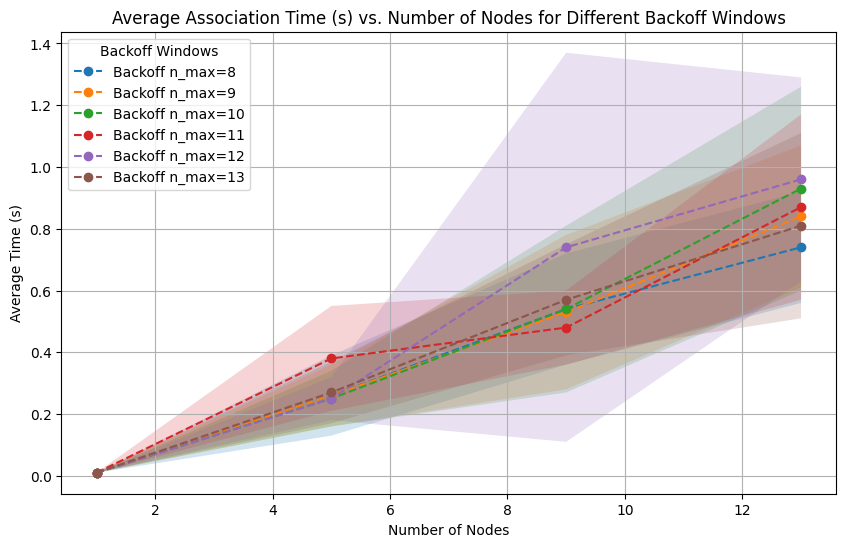

In [1533]:
def run_association_simulations(sf, splits_nodes=4, range_backoff=range(8, 14), number_of_runs=20):
        
    records = []

    splits_nodes = 4
    range_backoff = range(8, 14)
    number_of_runs = 20 # number of runs for each configuration

    print(f"Running:")
    for n_nodes in range(1, sf.max_nodes() + 1, int(sf.max_nodes() / splits_nodes)):
        # print(f" n ", end="")
        print(f"  n_nodes = {n_nodes}, backoff_n_max= ", end="")
        for backoff_n_max in range_backoff:
            # print(f"b ", end="")
            print(backoff_n_max, end=" ")
            times = [
                AssocTimeSimulation(SimConfig(sf, n_nodes, debug=False, backoff_n_max=backoff_n_max)).run().duration
                for _ in range(number_of_runs)
            ]
            # get avg and std
            records.append({
                "n_nodes": n_nodes,
                "backoff_n_max": backoff_n_max,
                "avg": round(np.mean(times) / 1000, 2),
                "std": round(np.std(times) / 1000, 2),
            })
        print("")
    print("")

    df = pd.DataFrame(records)
    # display(df)
    return df

def plot_association_simulation_results(df):
    # plot
    plt.figure(figsize=(10, 6))

    # Group by backoff_n_max and plot each group with different colors
    for backoff_n_max, group in df.groupby('backoff_n_max'):
        plt.plot(
            group['n_nodes'],
            group['avg'],
            '--o',
            label=f'Backoff n_max={backoff_n_max}'
        )
        plt.fill_between(
            group['n_nodes'],
            group['avg'] - group['std'],
            group['avg'] + group['std'],
            alpha=0.2  # Apply transparency to shading
        )

    # Add labels and legend
    plt.xlabel('Number of Nodes')
    plt.ylabel('Average Time (s)')
    plt.title('Average Association Time (s) vs. Number of Nodes for Different Backoff Windows')
    plt.grid(True)
    plt.legend(title='Backoff Windows')
    plt.show()

print("For this slotframe configuration:")
sf_simple.show(compact=True)

df = run_association_simulations(sf_simple)
plot_association_simulation_results(df)